In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Feb 20 15:10:00 2018

@author: Yacalis
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from Callbacks import Callbacks
from Config import Config
from dataLoader import retrieve_celeba_data
from folder_defs import get_log_dir, get_data_dir, get_train_dir, get_test_dir, get_celeba_dir
from build_model import build_model
from save_model import save_model
from get_data_dict import get_celeba_data

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# get config
config = Config().config
# Model checkpoint
config.period = 20
# ReduceLROnPlateau
config.lr_min_lr = 1e-07
config.lr_epsilon = 0.001
config.lr_factor = 0.5
config.lr_patience = 3
# Early stopping
config.es_min_delta = 0.001
# Training and testing
config.epochs = 40
config.batch_size = 4
num_images = 20000
batch_size_mult = 2
# Optimizer
optimizer = Adam(lr=0.001,  # 0.001
                 beta_1=0.9,  # 0.9
                 beta_2=0.999,  # 0.999
                 epsilon=1e-08,  # 1e-08
                 decay=0.0)  # 0.0

unparsed config options: ['-f', '/Users/Yacalis/Library/Jupyter/runtime/kernel-11ca5ed3-476f-45dc-b225-b133691b56ba.json']


In [3]:
# For the case in which there is no change in the parameters:
# config.change_lr = False
# config.change_bs = False
# config.es_patience = 10

# For the case in which we change the learning rate:
# config.change_lr = True
# config.change_bs = False
# config.es_patience = 10

# For the case in which we change the batch size:
config.change_lr = False
config.change_bs = True
config.es_patience = 3

In [4]:
# get directories
log_dir = get_log_dir(config)
data_dir = get_data_dir()
image_dir = get_celeba_dir()

# get data
data_dict = get_celeba_data(data_dir)

# instantiate arrays
x_data = []
y_data = []
keys = data_dict.keys()
i = 1
images = os.listdir(image_dir)
shuffle(images)

data file:  /Users/Yacalis/Projects/Tensorflow/cs274c-data/celeba/list_attr.csv
number of records from data file:  159202


In [5]:
# load x and y data
try:
    for file in images:
        if i > num_images:
            break
        if file in keys:
            filepath = os.path.join(image_dir, file)
            im_arr = mpimg.imread(filepath)
            if im_arr.shape == (218, 178, 3):
                x_data.append(im_arr)
                y_data.append(np.array(data_dict[file][0]))
                i += 1
except Exception as e:
    print(str(e))

In [6]:
# turn into numpy arrays
x_data = np.array(x_data)
y_data = np.array(y_data)
print('x_data shape:', x_data.shape)
print('y_data shape, num_males, percent_males:', y_data.shape, sum(y_data[:,1]), sum(y_data[:,1])/y_data.shape[0])

x_data shape: (20000, 218, 178, 3)
y_data shape, num_males, percent_males: (20000, 3) 10023 0.50115


In [7]:
# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=True)
num_train = int(x_train.shape[0] * 0.8)
print(f'Num training examples (excludes test and val): {num_train}')
print('y_data shape, num_males, percent_males:', y_train.shape, sum(y_train[:,1]), sum(y_train[:,1])/y_data.shape[0])

Num training examples (excludes test and val): 12800
y_data shape, num_males, percent_males: (16000, 3) 7998 0.3999


In [8]:
# build model
input_dim = x_train[0].shape

model = Sequential()
model.add(Conv2D(3,
                 kernel_size=(3, 3),
                 strides=(2, 2),
                 activation='relu',
                 padding='same',
                 input_shape=input_dim))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=3, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 109, 89, 3)        84        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 44, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 54, 44, 3)         12        
_________________________________________________________________
flatten_1 (Flatten)          (None, 7128)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7128)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                456256    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

In [9]:
# training

# get callbacks
callbacks = Callbacks(config, log_dir).callbacks
print('callbacks:')
for callback in callbacks:
    print('\t', callback)

# set variables
val_loss = []
val_acc = []
loss = []
acc = []
lr = []
bs = []
epoch_iter = 1
max_epochs = config.epochs
batch_size = config.batch_size

# train model
if config.change_lr:  # reduce_lr callback takes care of everything for us
    print('Will change learning rate during training, but not batch size')
    print('Training model...')
    history = model.fit(x_train,
                        y_train,
                        epochs=max_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=1,
                        callbacks=callbacks)
    # store history (bs is constant)
    val_loss += history.history['val_loss']
    val_acc += history.history['val_acc']
    loss += history.history['loss']
    acc += history.history['acc']
    lr += history.history['lr']
    bs = [batch_size for i in range(len(history.epoch))]

elif config.change_bs:  # need to manually stop and restart training
    print('Will change batch size during training, but not learning rate')
    while max_epochs >= epoch_iter:
        print(f'Currently at epoch {epoch_iter} of {max_epochs}, batch size is {batch_size}')
        epochs = max_epochs - epoch_iter + 1
        history = model.fit(x_train,
                            y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_split=0.2,
                            verbose=1,
                            callbacks=callbacks)
        # store history
        val_loss += history.history['val_loss']
        val_acc += history.history['val_acc']
        loss += history.history['loss']
        acc += history.history['acc']
        bs += [batch_size for i in range(len(history.epoch))]

        # update training parameters
        epoch_iter += len(history.epoch)
        batch_size *= batch_size_mult
        batch_size = batch_size if batch_size < num_train else num_train

    # store lr history as constant (because it is)
    lr = [0.001 for i in range(len(bs))]

else:
    print('Will not change learning rate nor batch size during training')
    print('Training model...')
    history = model.fit(x_train,
                        y_train,
                        epochs=max_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=1,
                        callbacks=callbacks)
    # store history (bs is constant)
    val_loss += history.history['val_loss']
    val_acc += history.history['val_acc']
    loss += history.history['loss']
    acc += history.history['acc']
    lr = [0.001 for i in range(len(history.epoch))]
    bs = [batch_size for i in range(len(history.epoch))]

print('Completed training')

callbacks:
Will change batch size during training, but not learning rate
Currently at epoch 1 of 40, batch size is 4
Train on 12800 samples, validate on 3200 samples
Epoch 1/40
12800/12800 [==============================] - 94s 7ms/step - loss: 0.5090 - acc: 0.7521 - val_loss: 0.3295 - val_acc: 0.8749
Epoch 2/40
12800/12800 [==============================] - 90s 7ms/step - loss: 0.3510 - acc: 0.8419 - val_loss: 0.2860 - val_acc: 0.8917
Epoch 3/40
12800/12800 [==============================] - 95s 7ms/step - loss: 0.3049 - acc: 0.8649 - val_loss: 0.2521 - val_acc: 0.9108
Epoch 4/40
12800/12800 [==============================] - 96s 8ms/step - loss: 0.2787 - acc: 0.8798 - val_loss: 0.2494 - val_acc: 0.9032
Epoch 5/40
12800/12800 [==============================] - 95s 7ms/step - loss: 0.2591 - acc: 0.8887 - val_loss: 0.2337 - val_acc: 0.9180
Epoch 6/40
12800/12800 [==============================] - 93s 7ms/step - loss: 0.2475 - acc: 0.8957 - val_loss: 0.2283 - val_acc: 0.9151
Epoch 7/40
1

In [10]:
# save finished model
save_model(log_dir=log_dir, config=config, model=model)

# save loss, accuracy, lr, and bs values across epochs as json;
# have to force cast lr vals as float64 because history object saves them
# as float32, and json.dump() is not compatible with float32
acc_loss_lr_bs = {'val_loss': val_loss,
                  'val_acc': val_acc,
                  'loss': loss,
                  'acc': acc,
                  'lr': [np.float64(i) for i in lr],
                  'bs': bs
                  }
acc_loss_lr_bs_path = os.path.join(log_dir, 'acc_loss_lr_bs.json')
with open(acc_loss_lr_bs_path, 'w') as f:
    json.dump(acc_loss_lr_bs, f, indent=4, sort_keys=True)

Saving model...
Model saved


In [11]:
# evaluate model (on original batch size)
print('Calculating final score...')
score = model.evaluate(x_test, y_test, batch_size=config.batch_size)
print('Final score:', score)

Calculating final score...
4000/4000 [==============================] - 13s 3ms/step
Final score: [0.175738136541564, 0.9313333473205566]


number all_true: 848 / 1010
percent all_true: 0.8396039603960396


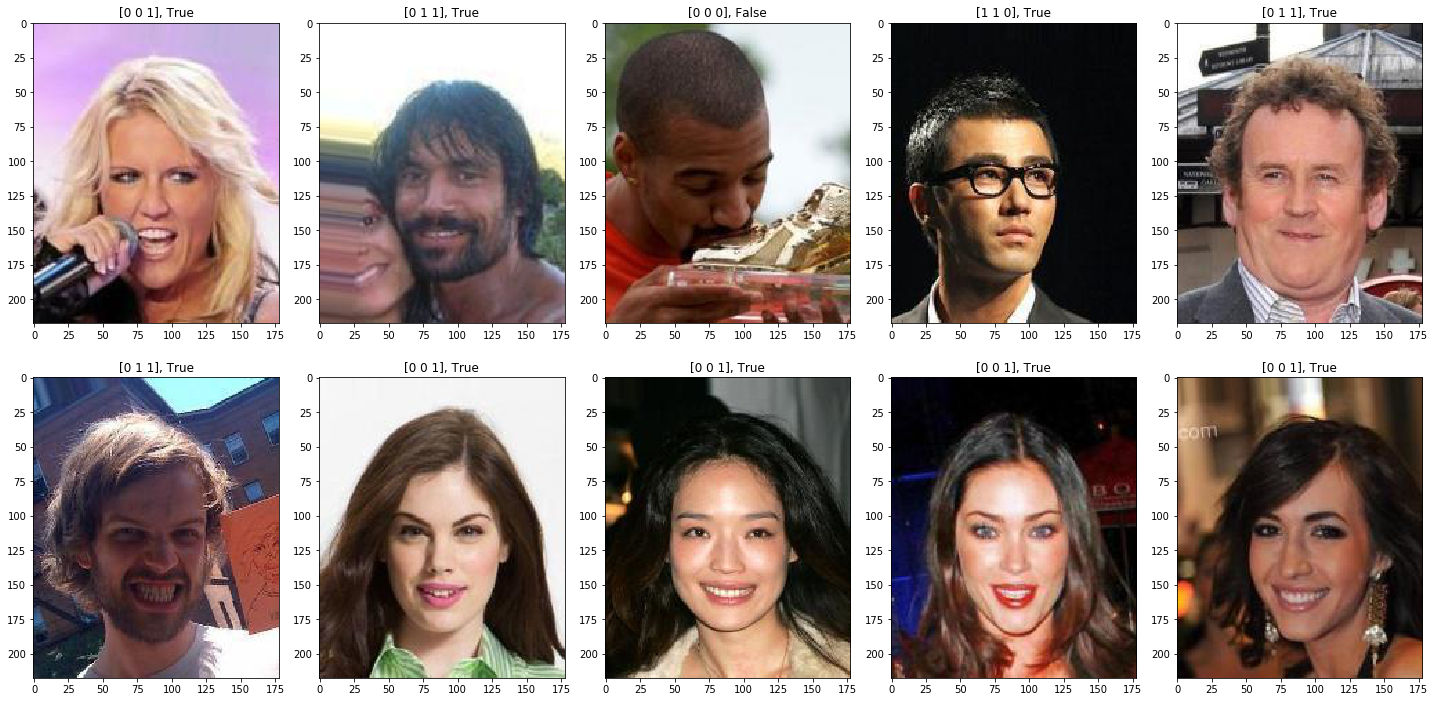

In [46]:
# show examples
plt.figure(figsize=(20,10))
columns = 5
k = 0
max_iter = 9
y_true = []
y_pred = []
all_true = 0
while k < (max_iter + 1):
    rando = np.random.randint(0, len(x_test) - 1)
    image = x_test[rando]
    plt.subplot((max_iter - 1) / columns + 1, columns, k + 1)
    plt.imshow(image)
    
    pred = model.predict(np.expand_dims(x_test[rando], axis=0))
    pick_binary = np.vectorize(lambda x: 0 if x < 0.5 else 1)
    guess = pick_binary(pred)
    match = np.alltrue(np.equal(y_test[rando], guess[0]))
    all_true += 1 if match else 0
    plt.title(f'{guess[0]}, {match}')
    y_true.append(y_test[rando])
    y_pred.append(guess[0])
    k += 1

k = 0
while k < 1000:
    rando = np.random.randint(0, len(x_test) - 1)
    pred = model.predict(np.expand_dims(x_test[rando], axis=0))
    pick_binary = np.vectorize(lambda x: 0 if x < 0.5 else 1)
    guess = pick_binary(pred)
    match = np.alltrue(np.equal(y_test[rando], guess[0]))
    all_true += 1 if match else 0
    y_true.append(y_test[rando])
    y_pred.append(guess[0])
    k += 1
    
print('number all_true:', all_true, '/', len(y_true))
print('percent all_true:', all_true/len(y_true))
y_true = np.array(y_true)
y_pred = np.array(y_pred)
plt.tight_layout()


In [13]:
class_names = ['Glasses', "Male", "Smiling"]
print(classification_report(y_true, y_pred, target_names=class_names))

             precision    recall  f1-score   support

    Glasses       0.94      0.89      0.92        75
       Male       0.90      0.97      0.93       542
    Smiling       0.93      0.83      0.88       458

avg / total       0.92      0.91      0.91      1075



In [2]:
from keras.models import load_model

In [3]:
logdir = '/Users/Yacalis/Projects/TensorFlow/cs274c-data/logs'

In [31]:
# get all true and all false examples from test set, as well as percent of total
def get_all_true(x_test, model):
    all_true_x = []
    all_true_y = []
    all_false_x = []
    all_false_y = []
    num_samples = x_test.shape[0]
    
    for i in range(num_samples):
        pred = model.predict(np.expand_dims(x_test[i], axis=0))
        pick_binary = np.vectorize(lambda x: 0 if x < 0.5 else 1)
        b_pred = pick_binary(pred)
        
        equal = np.equal(y_test[i], b_pred[0])
        if not equal[0] and not equal[1] and not equal[2]:
            all_false_x.append(x_test[i])
            all_false_y.append(y_test[i])
        
        match = np.alltrue(equal)
        if match:
            all_true_x.append(x_test[i])
            all_true_y.append(y_test[i])
    
    all_true_x = np.array(all_true_x)
    all_true_y = np.array(all_true_y)
    all_false_x = np.array(all_false_x)
    all_false_y = np.array(all_false_y)
    
    percent_all_true = all_true_x.shape[0] / num_samples
    percent_all_false = all_false_x.shape[0] / num_samples
    
    return all_true_x, all_true_y, all_false_x, all_false_y, percent_all_true, percent_all_false

In [4]:
model = load_model(os.path.join(logdir, '0314_0049-clr-v_celeba', 'model.hdf5'))

In [37]:
all_true_x, all_true_y, all_false_x, all_false_y, percent_all_true, percent_all_false = get_all_true(x_test, model)
print(percent_all_true, percent_all_false, all_false_x.shape)

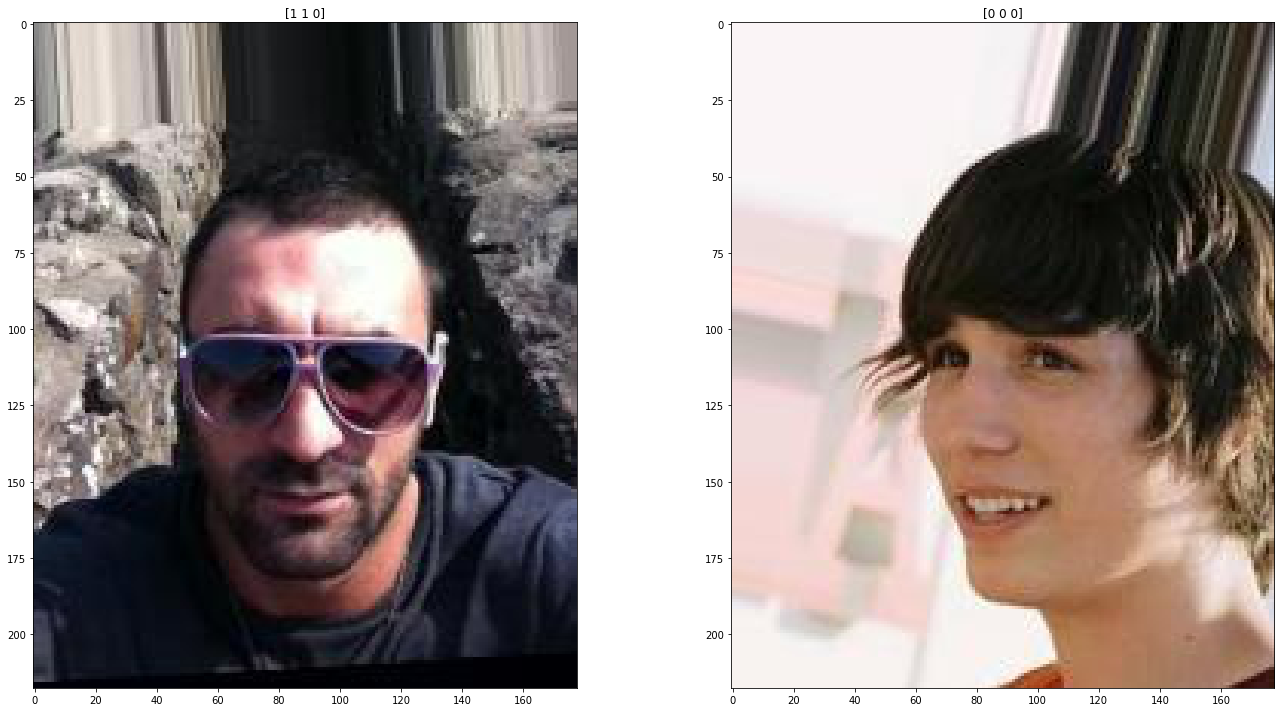

In [42]:
# show examples
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(all_true_x[2])
plt.title(f'{all_true_y[2]}')
plt.subplot(1, 2, 2)
plt.imshow(all_false_x[0])
plt.title(f'{all_false_y[0]}')

plt.tight_layout()

In [77]:
# new task

In [54]:
no_change_json = os.path.join(logdir, '0313_2343-v_celeba', 'acc_loss_lr_bs.json')
lr_json = os.path.join(logdir, '0314_0049-clr-v_celeba', 'acc_loss_lr_bs.json')
bs_json = os.path.join(logdir, '0314_0214-cbs-v_celeba', 'acc_loss_lr_bs.json')

In [55]:
with open(no_change_json) as fd:
    nc_dict = json.load(fd)
with open(lr_json) as fd:
    lr_dict = json.load(fd)
with open(bs_json) as fd:
    bs_dict = json.load(fd)

In [56]:
print(nc_dict.keys(), lr_dict.keys(), bs_dict.keys(), sep='\n')

dict_keys(['acc', 'bs', 'loss', 'lr', 'val_acc', 'val_loss'])
dict_keys(['acc', 'bs', 'loss', 'lr', 'val_acc', 'val_loss'])
dict_keys(['acc', 'bs', 'loss', 'lr', 'val_acc', 'val_loss'])


In [60]:
epoch_range = np.arange(40)

In [73]:
# pull out arrays
nc_val_acc = nc_dict['val_acc']
lr_val_acc = lr_dict['val_acc']
bs_val_acc = bs_dict['val_acc']
nc_acc = nc_dict['acc']
lr_acc = lr_dict['acc']
bs_acc = bs_dict['acc']

nc_val_loss = nc_dict['val_loss']
lr_val_loss = lr_dict['val_loss']
bs_val_loss = bs_dict['val_loss']
nc_loss = nc_dict['loss']
lr_loss = lr_dict['loss']
bs_loss = bs_dict['loss']

lr_lr = lr_dict['lr']
bs_bs = bs_dict['bs']

In [74]:
# get arrays to all be the same length as epoch_range
def match_array_length(long_arr, short_arr):
    longlen = len(long_arr)
    shortlen = len(short_arr)
    if shortlen < longlen:
        diff = longlen - shortlen
        last = shortlen - 1
        for i in range(diff):
            short_arr.append(short_arr[last])
    return short_arr

In [75]:
# get arrays to all be the same length as epoch_range
nc_val_acc = match_array_length(epoch_range, nc_val_acc)
lr_val_acc = match_array_length(epoch_range, lr_val_acc)
bs_val_acc = match_array_length(epoch_range, bs_val_acc)
nc_acc = match_array_length(epoch_range, nc_acc)
lr_acc = match_array_length(epoch_range, lr_acc)
bs_acc = match_array_length(epoch_range, bs_acc)
nc_val_loss = match_array_length(epoch_range, nc_val_loss)
lr_val_loss = match_array_length(epoch_range, lr_val_loss)
bs_val_loss = match_array_length(epoch_range, bs_val_loss)
nc_loss = match_array_length(epoch_range, nc_loss)
lr_loss = match_array_length(epoch_range, lr_loss)
bs_loss = match_array_length(epoch_range, bs_loss)
lr_lr = match_array_length(epoch_range, lr_lr)
bs_bs = match_array_length(epoch_range, bs_bs)

In [134]:
bs_val_acc[-1]

0.9296874713897705

In [88]:
import seaborn
import matplotlib.patches as mpatches

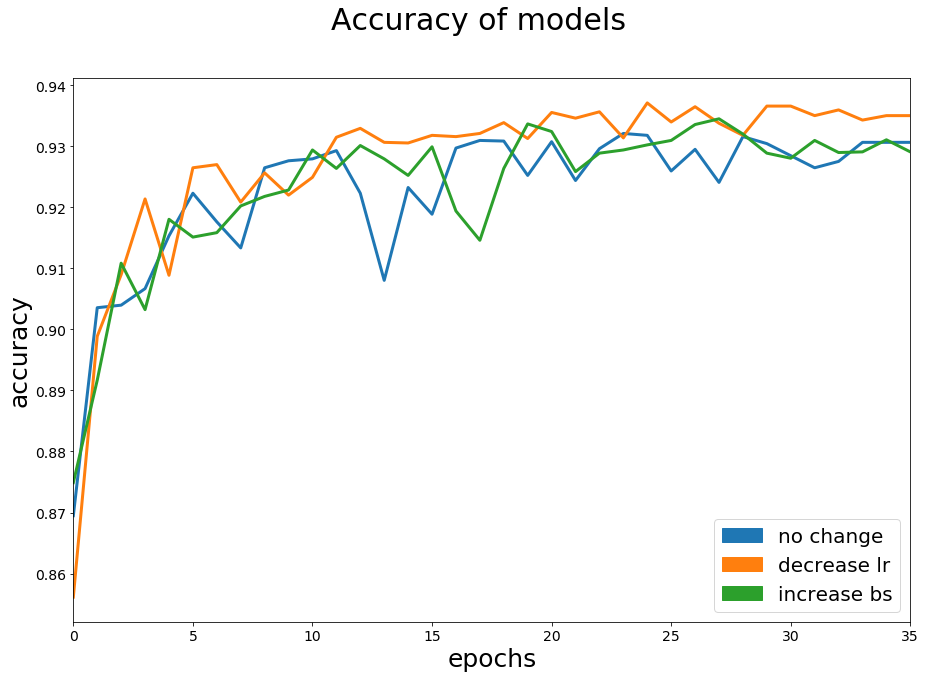

In [145]:
# plot val_acc vs epochs
plt.figure(figsize=(15,10))
plt.plot(epoch_range, nc_dict['val_acc'], linewidth=3) # no change
plt.plot(epoch_range, lr_dict['val_acc'], linewidth=3) # lr
plt.plot(epoch_range, bs_dict['val_acc'], linewidth=3) # bs
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlim([0,35])
red_patch = mpatches.Patch(label='no change', color=current_palette[0])
green_patch = mpatches.Patch(label='decrease lr', color=current_palette[1])
blue_patch = mpatches.Patch(label='increase bs', color=current_palette[2])
plt.legend(handles=[red_patch, green_patch, blue_patch], loc=4, prop={'size': 20})
plt.suptitle('Accuracy of models', fontsize=30)
plt.xlabel('epochs', fontsize=25)
plt.ylabel('accuracy', fontsize=25)
plt.savefig('accuracy.jpg')
plt.show()

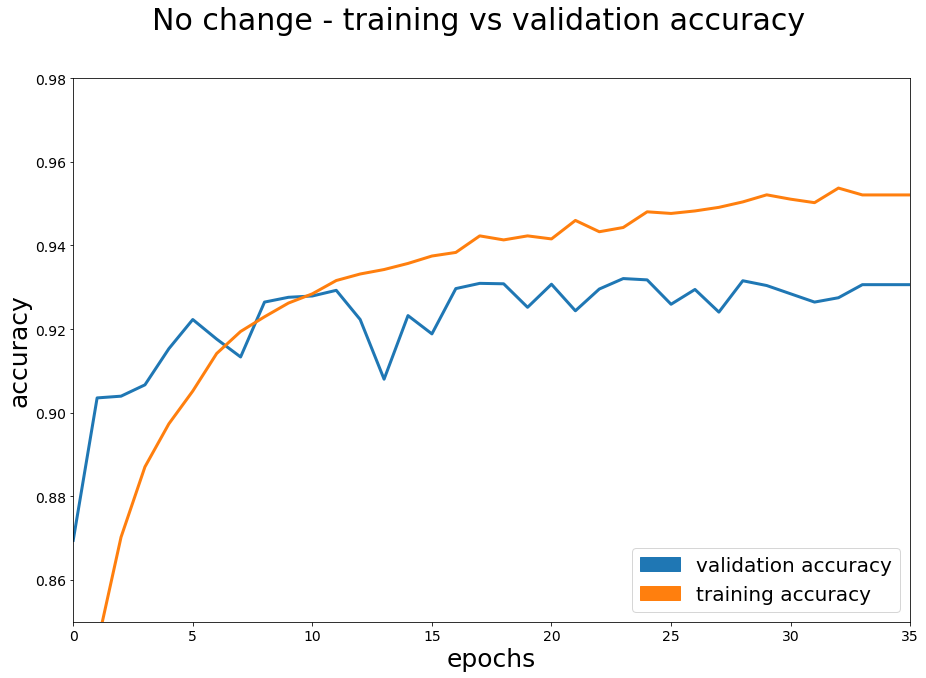

In [147]:
# plot val_acc vs epochs
plt.figure(figsize=(15,10))
plt.plot(epoch_range, nc_dict['val_acc'], linewidth=3) # no change
plt.plot(epoch_range, nc_dict['acc'], linewidth=3) # lr
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlim([0,35])
plt.ylim([0.85,0.98])
red_patch = mpatches.Patch(color=current_palette[0], label='validation accuracy')
green_patch = mpatches.Patch(color=current_palette[1], label='training accuracy')
plt.legend(handles=[red_patch, green_patch], loc=4, prop={'size': 20})
plt.suptitle('No change - training vs validation accuracy', fontsize=30)
plt.xlabel('epochs', fontsize=25)
plt.ylabel('accuracy', fontsize=25)
plt.savefig('nc_accuracy.jpg')
plt.show()

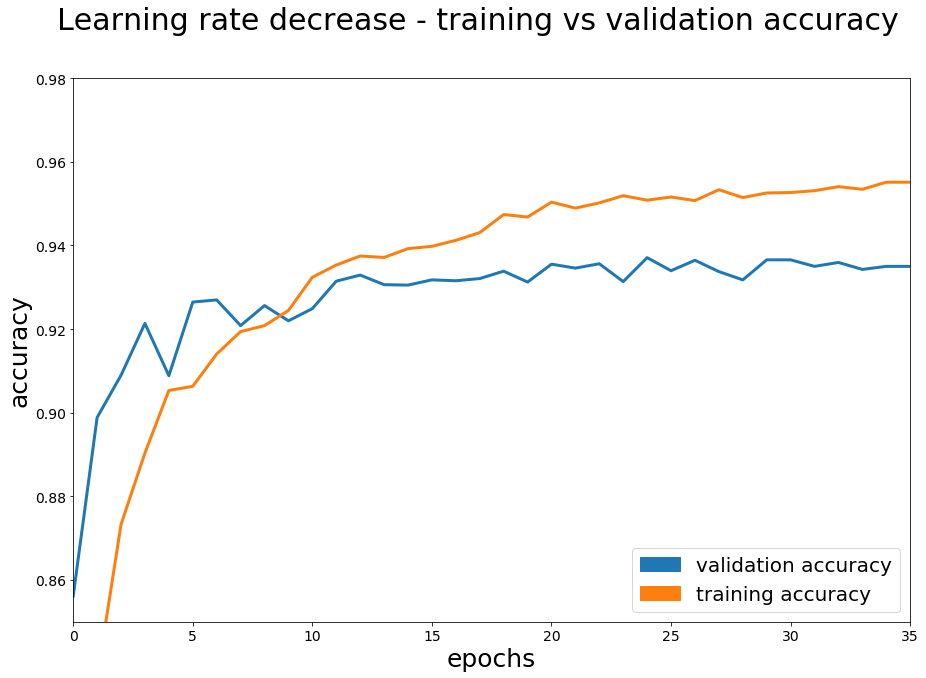

In [151]:
# plot val_acc vs epochs
plt.figure(figsize=(15,10))
plt.plot(epoch_range, lr_dict['val_acc'], linewidth=3) # no change
plt.plot(epoch_range, lr_dict['acc'], linewidth=3) # lr
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlim([0,35])
plt.ylim([0.85,0.98])
red_patch = mpatches.Patch(color=current_palette[0], label='validation accuracy')
green_patch = mpatches.Patch(color=current_palette[1], label='training accuracy')
plt.legend(handles=[red_patch, green_patch], loc=4, prop={'size': 20})
plt.suptitle('Learning rate decrease - training vs validation accuracy', fontsize=30)
plt.xlabel('epochs', fontsize=25)
plt.ylabel('accuracy', fontsize=25)
plt.savefig('lr_accuracy.jpg')
plt.show()

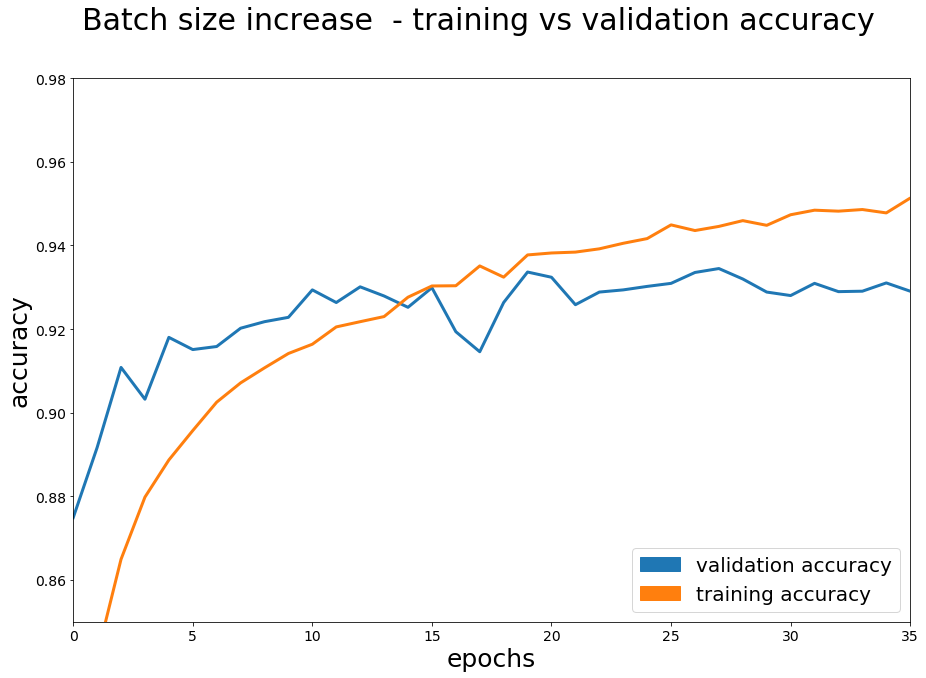

In [152]:
# plot val_acc vs epochs
plt.figure(figsize=(15,10))
plt.plot(epoch_range, bs_dict['val_acc'], linewidth=3) # no change
plt.plot(epoch_range, bs_dict['acc'], linewidth=3) # lr
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlim([0,35])
plt.ylim([0.85,0.98])
red_patch = mpatches.Patch(color=current_palette[0], label='validation accuracy')
green_patch = mpatches.Patch(color=current_palette[1], label='training accuracy')
plt.legend(handles=[red_patch, green_patch], loc=4, prop={'size': 20})
plt.suptitle('Batch size increase  - training vs validation accuracy', fontsize=30)
plt.xlabel('epochs', fontsize=25)
plt.ylabel('accuracy', fontsize=25)
plt.savefig('bs_accuracy.jpg')
plt.show()

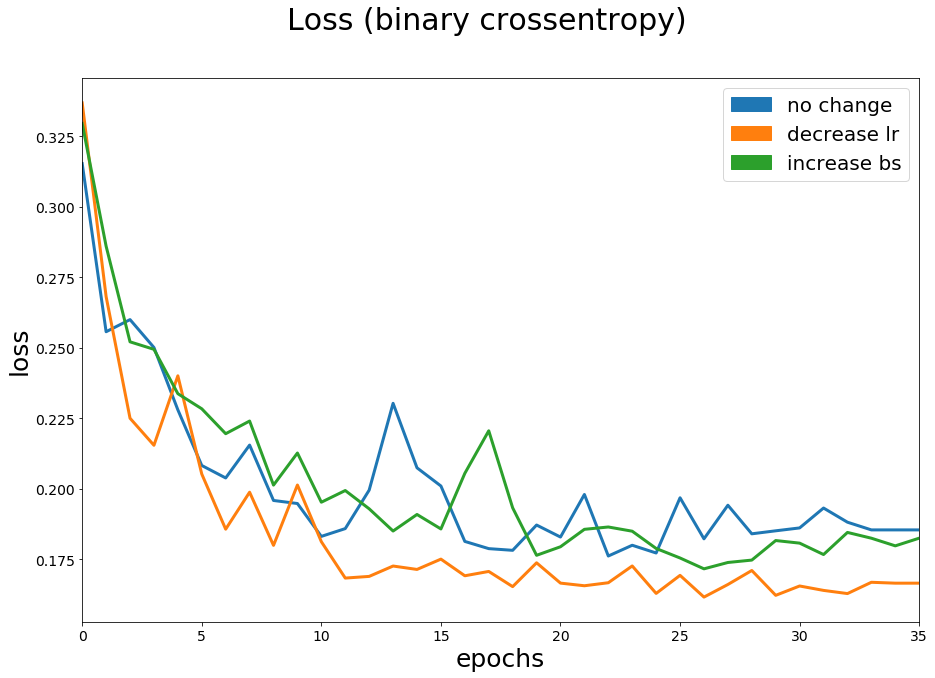

In [153]:
# plot val_acc vs epochs
plt.figure(figsize=(15,10))
plt.plot(epoch_range, nc_dict['val_loss'], linewidth=3) # no change
plt.plot(epoch_range, lr_dict['val_loss'], linewidth=3) # lr
plt.plot(epoch_range, bs_dict['val_loss'], linewidth=3) # bs
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlim([0,35])
red_patch = mpatches.Patch(color=current_palette[0], label='no change')
green_patch = mpatches.Patch(color=current_palette[1], label='decrease lr')
blue_patch = mpatches.Patch(color=current_palette[2], label='increase bs')
plt.legend(handles=[red_patch, green_patch, blue_patch], loc=1, prop={'size': 20})
plt.suptitle('Loss (binary crossentropy)', fontsize=30)
plt.xlabel('epochs', fontsize=25)
plt.ylabel('loss', fontsize=25)
plt.savefig('loss.jpg')
plt.show()

In [141]:
current_palette = seaborn.color_palette()
current_palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [8]:
# new task
from PIL import Image
import numpy as np

In [19]:
img = Image.open('')
img = img.resize((218, 178))
img = np.array(img)
print(type(img), img.shape)

<class 'numpy.ndarray'> (178, 218, 3)


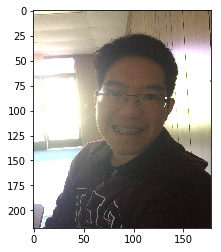

In [20]:
plt.imshow(img.swapaxes(0,1))

In [22]:
pred = model.predict(np.expand_dims(img.swapaxes(0,1), axis=0))

In [23]:
pick_binary = np.vectorize(lambda x: 0 if x < 0.5 else 1)
guess = pick_binary(pred)
guess

array([[0, 1, 0]])

In [24]:
pred

array([[3.5175585e-04, 9.9993563e-01, 1.6971391e-02]], dtype=float32)